In [1]:

import sys
sys.path.append('/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/models/')
sys.path.append('/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import comp_models
import utils
import seaborn as sns


dat = pd.read_csv('../Data/bx_data.csv', index_col=0)
fits = pd.read_csv('../Results/final_model_fits2turker_all.csv', index_col=0)
# add p2 index to mod_fit df
fits['p2'] = np.nan
for p2 in dat.trustee.unique():
    p2_turkers = dat.loc[dat.trustee == p2, 'turker_id'].unique()
    fits.loc[fits.turker.isin(p2_turkers), 'p2'] = int(p2)

### Cross Validation
**test set**: 4 player twos (1 of each strategy) x 20 player 3 each = 80 games
**training set**: 16 player twos (4 of each strategy) x 20 player 3 each = 320 game

In [2]:
def training(trainDat, model):
    mod_fits = fits.loc[fits.model == model].reset_index(drop=True)
    #"train model" i.e. mean param values for training set
    param1 = mod_fits.loc[mod_fits.turker.isin(trainDat.turker_id.unique()), 'param1'].mean()
    param2 = mod_fits.loc[mod_fits.turker.isin(trainDat.turker_id.unique()), 'param2'].mean()
    return [param1, param2]

# predict the test dat
def testing(testDat, model, param1, param2):
    testDat[model+'mod_pred'] = np.nan
    for p3 in testDat.turker_id.unique():
        g = testDat.loc[testDat.turker_id == p3]
        if model == 'inverse RL':
            mod_preds = comp_models.imm_learn(g, utils.folk_params, param1, param2).astype(int).tolist()
        elif model == 'Rescorla-Wagner':
            mod_preds = comp_models.rw_learn(g, param1).tolist()

        testDat.loc[testDat.turker_id == p3, model+'mod_pred'] = mod_preds
    testDat[model+'_pe'] = abs((testDat[model+'mod_pred']/testDat.im)*100 - (testDat.ret/testDat.im)*100)
    return testDat


def evaluate(testDat, model):
    performance = []
    for turk in testDat.turker_id.unique():
        mod_pred = testDat.loc[testDat.turker_id == turk, model+'mod_pred']
        sub_pred = testDat.loc[testDat.turker_id == turk, 'pred']
        performance.append(sum((mod_pred - sub_pred)**2))
    return np.mean(performance)

In [3]:
# Leave 5 out CV
'''
# Separate the data
p2strats = ['GR', 'GA', 'IA', 'MO']
test_p2s = []
for strat in p2strats:
    pTwos = dat.loc[dat.p2_strat == strat, 'trustee'].unique()
    test_p2s.append(pTwos[np.random.randint(len(pTwos))])

testDat = dat.loc[dat.trustee.isin(test_p2s)]
trainDat = dat.loc[~dat.trustee.isin(test_p2s)]

#Train
alpha, tau = training(trainDat, 'inverse RL')
rw_alpha, param2 = training(trainDat, 'Rescorla-Wagner')
#Test
testDat = testing(testDat, 'inverse RL', alpha, tau)
testDat = testing(testDat, 'Rescorla-Wagner', rw_alpha, param2)
#Evaluate
perfom_eval = evaluate(testDat, 'inverse RL')
'''

"\n# Separate the data\np2strats = ['GR', 'GA', 'IA', 'MO']\ntest_p2s = []\nfor strat in p2strats:\n    pTwos = dat.loc[dat.p2_strat == strat, 'trustee'].unique()\n    test_p2s.append(pTwos[np.random.randint(len(pTwos))])\n\ntestDat = dat.loc[dat.trustee.isin(test_p2s)]\ntrainDat = dat.loc[~dat.trustee.isin(test_p2s)]\n\n#Train\nalpha, tau = training(trainDat, 'inverse RL')\nrw_alpha, param2 = training(trainDat, 'Rescorla-Wagner')\n#Test\ntestDat = testing(testDat, 'inverse RL', alpha, tau)\ntestDat = testing(testDat, 'Rescorla-Wagner', rw_alpha, param2)\n#Evaluate\nperfom_eval = evaluate(testDat, 'inverse RL')\n"

In [4]:
results = pd.DataFrame(columns=['K', 'test_p2s', 'param1', 'param2', 'model', 'meanSSE'])
predictions = pd.DataFrame(columns=['trustee', 'trial','K', 'p2_strat', 'agent', 'error' ])

GR_p2s = dat.loc[dat.p2_strat =='GR', 'trustee'].unique()
GA_p2s = dat.loc[dat.p2_strat =='GA', 'trustee'].unique()
IA_p2s = dat.loc[dat.p2_strat =='IA', 'trustee'].unique()
MO_p2s = dat.loc[dat.p2_strat =='MO', 'trustee'].unique()
random.shuffle(GR_p2s)
random.shuffle(GA_p2s)
random.shuffle(IA_p2s)
random.shuffle(MO_p2s)

K = 5
for i in range(K):
    # choose hold out sample
    test_p2s = [GR_p2s[i],GA_p2s[i], IA_p2s[i],MO_p2s[i] ]
    # separate
    testDat = dat.loc[dat.trustee.isin(test_p2s)]
    trainDat = dat.loc[~dat.trustee.isin(test_p2s)]

    for model in ['inverse RL', 'Rescorla-Wagner']:
    # train
        param1, param2 = training(trainDat, model)
    # test
        testDat = testing(testDat, model, param1, param2)
    # evaluate
        performance = evaluate(testDat, model)

        results = results.append(pd.DataFrame([[i, test_p2s, param1, param2, model, performance]],
                                              columns=results.columns)).reset_index(drop=True)

    testDat['K'] = i
    predictions = predictions.append(testDat.melt(id_vars=['trustee','K', 'trial', 'p2_strat'],
                                                  value_vars=['turker_pe', 'inverse RL_pe', 'Rescorla-Wagner_pe'],
                                                  var_name='agent', value_name='error'))

/Users/bryangonzalez/opt/anaconda3/envs/mTurk/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/bryangonzalez/opt/anaconda3/envs/mTurk/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/bryangonzalez/opt/anaconda3/envs/mTurk/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to 

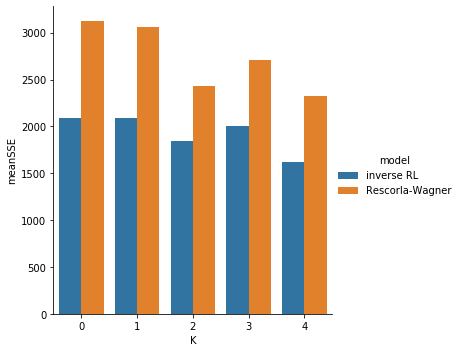

In [5]:
sns.catplot(x='K', y='meanSSE', hue='model', kind='bar', data=results)
#plt.savefig('5_fold_cv.png')

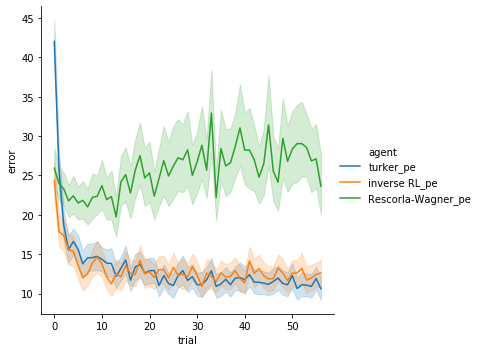

In [10]:
sns.relplot(x='trial', y='error', hue='agent', kind='line', data=predictions)
plt.savefig('CrossVal_K5_errors.png')

22800